# Домашнее задание «Модели авторегрессии условной гетероскедантичности»


Задание

* Выберите ряд из первого задания.
* Постройте его модель GARCH.

### импорт библиотек

In [68]:
from platform import python_version
import torch
import matplotlib

In [69]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.16
pandas==1.3.5
numpy==1.21.6
sklearn==1.0.2
torch==1.13.1
matplotlib==3.5.3


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import pandas as pd
import numpy as np
import tqdm
import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

from arch import arch_model

### загрузка данных

In [5]:
!wget !wget https://raw.githubusercontent.com/lteplova/tsml/main/Series/weekly-closings-of-the-dowjones-.csv

--2023-06-07 10:04:51--  http://!wget/
Resolving !wget (!wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address '!wget'
--2023-06-07 10:04:51--  https://raw.githubusercontent.com/lteplova/tsml/main/Series/weekly-closings-of-the-dowjones-.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2942 (2.9K) [text/plain]
Saving to: 'weekly-closings-of-the-dowjones-.csv'

weekly-closings-of- 100%[===================>]   2.87K  --.-KB/s    in 0s      

2023-06-07 10:04:51 (6.38 MB/s) - 'weekly-closings-of-the-dowjones-.csv' saved [2942/2942]

FINISHED --2023-06-07 10:04:51--
Total wall clock time: 0.4s
Downloaded: 1 files, 2.9K in 0s (6.38 MB/s)


In [6]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

### вспомогательные функции

In [7]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


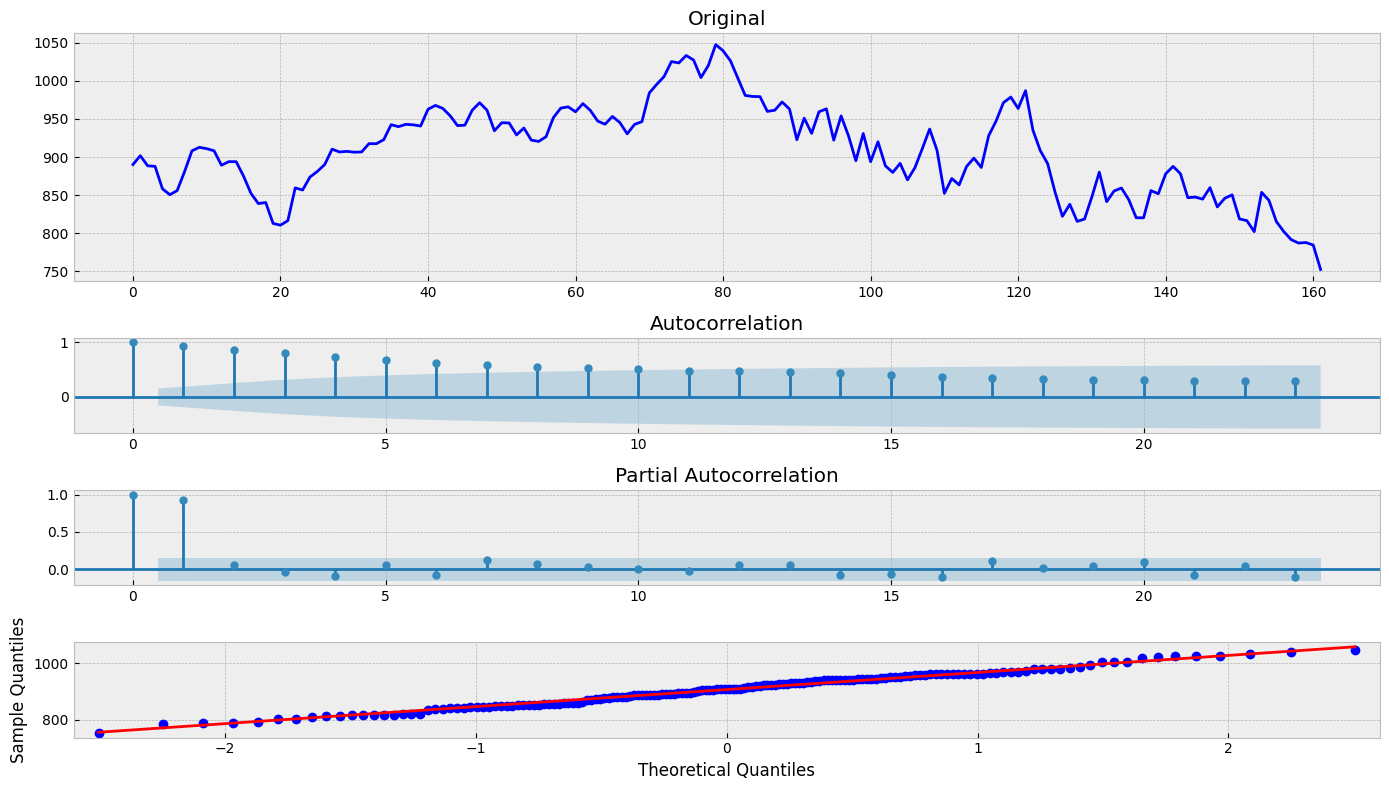

In [9]:
series = dowjones_closing
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


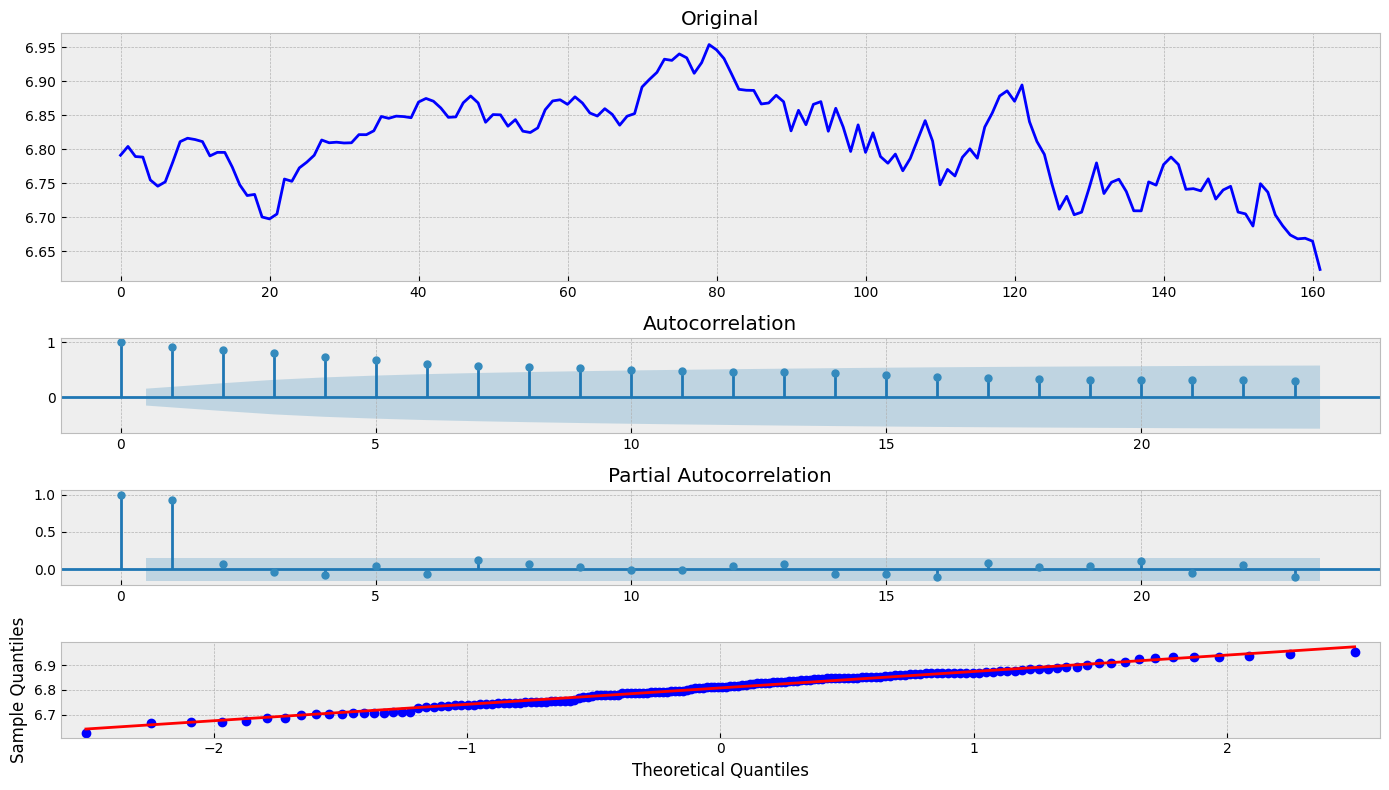

In [10]:
# преобразование БоксаКокса
series = boxcox(series, 0)
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


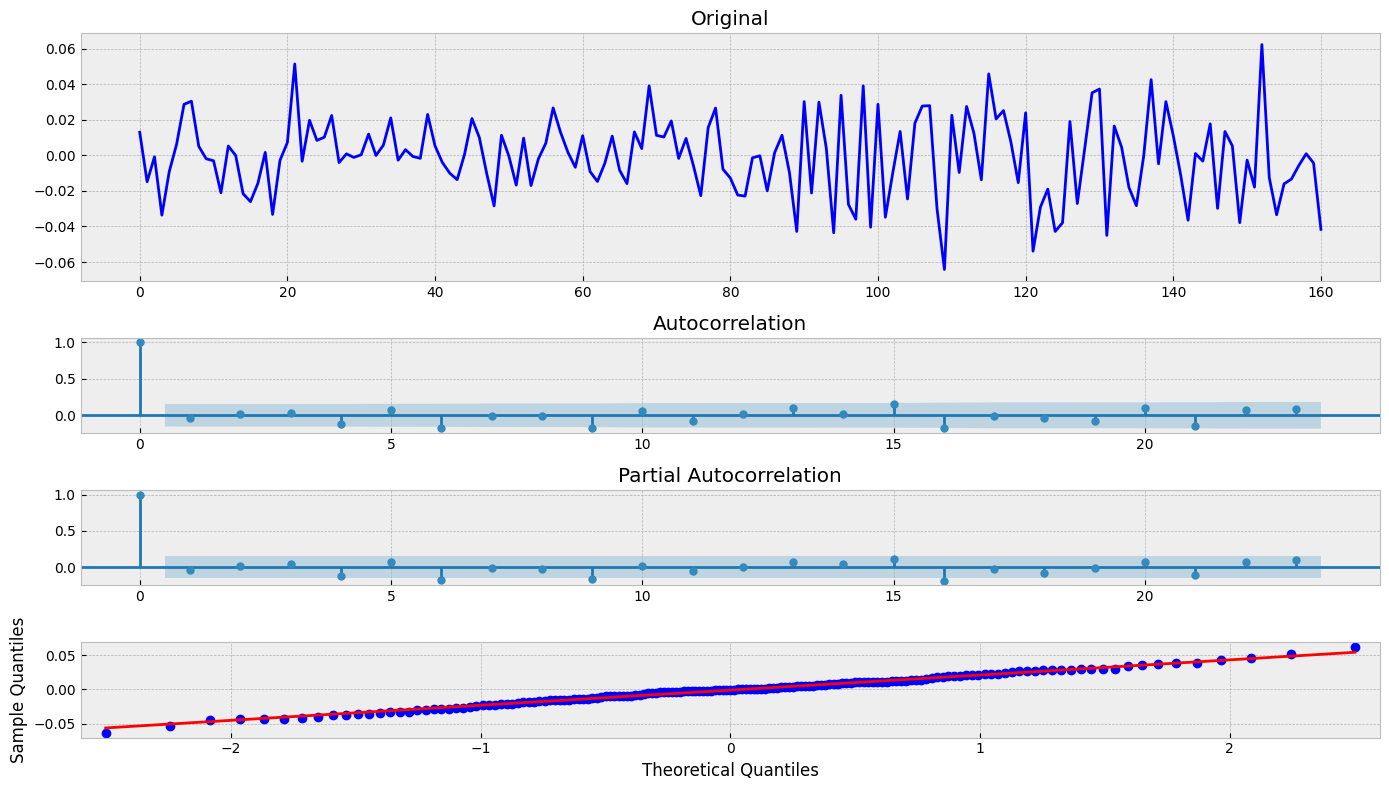

In [11]:
series = series[1:] - series[:-1]
tsplot(series)

#### применение GARCH

In [ ]:
# подбор гиперпараметров с помощью ARIMA
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

In [15]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -770.01581 | order: (2, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.183714e+01
p-value                        7.742721e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


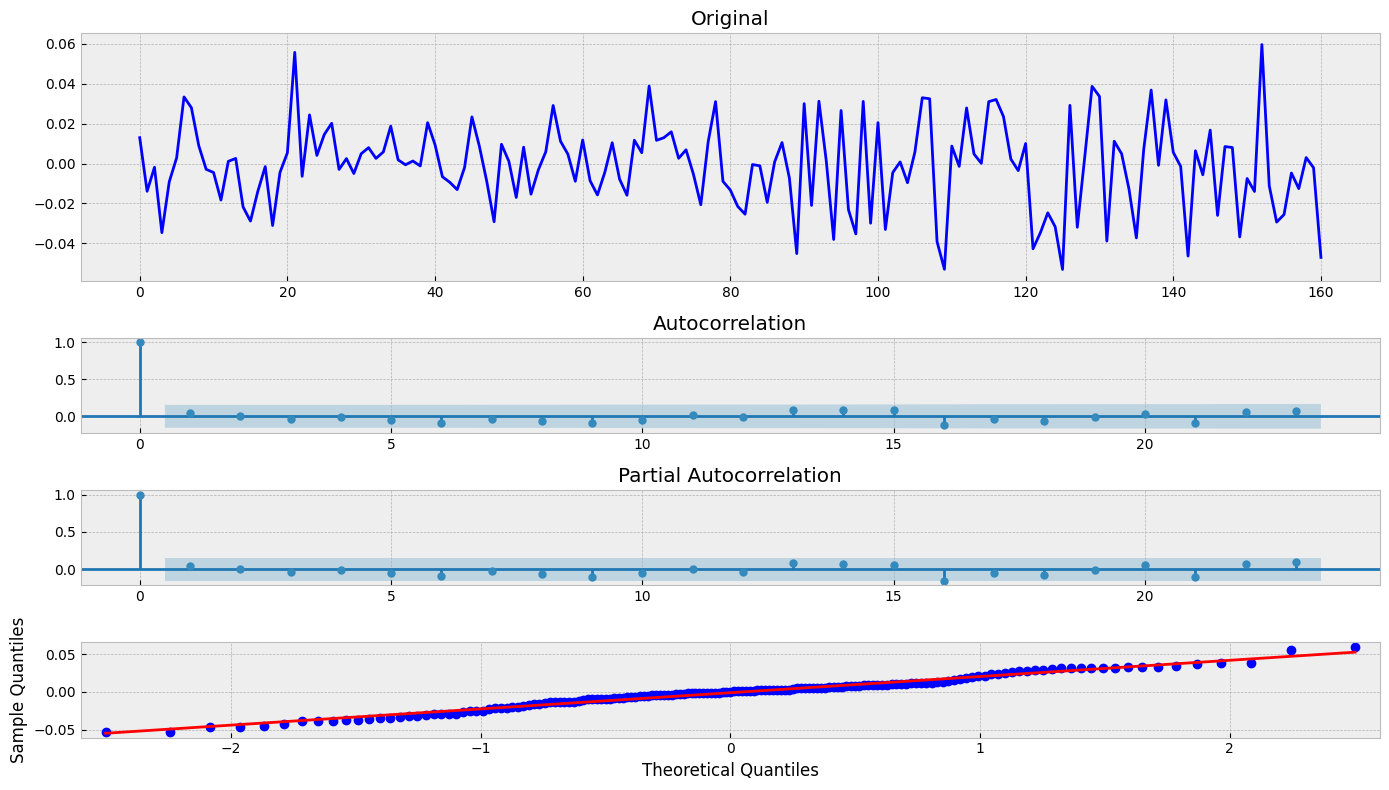

In [17]:
tsplot(mdl.resid)

In [26]:
# применим найденные с помощью ARIMA гиперпараметры для GARCH

am = arch_model(series, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                391.530
Distribution:      Standardized Student's t   AIC:                          -773.060
Method:                  Maximum Likelihood   BIC:                          -757.653
                                              No. Observations:                  161
Date:                      Wed, Jun 07 2023   Df Residuals:                      160
Time:                              11:33:39   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


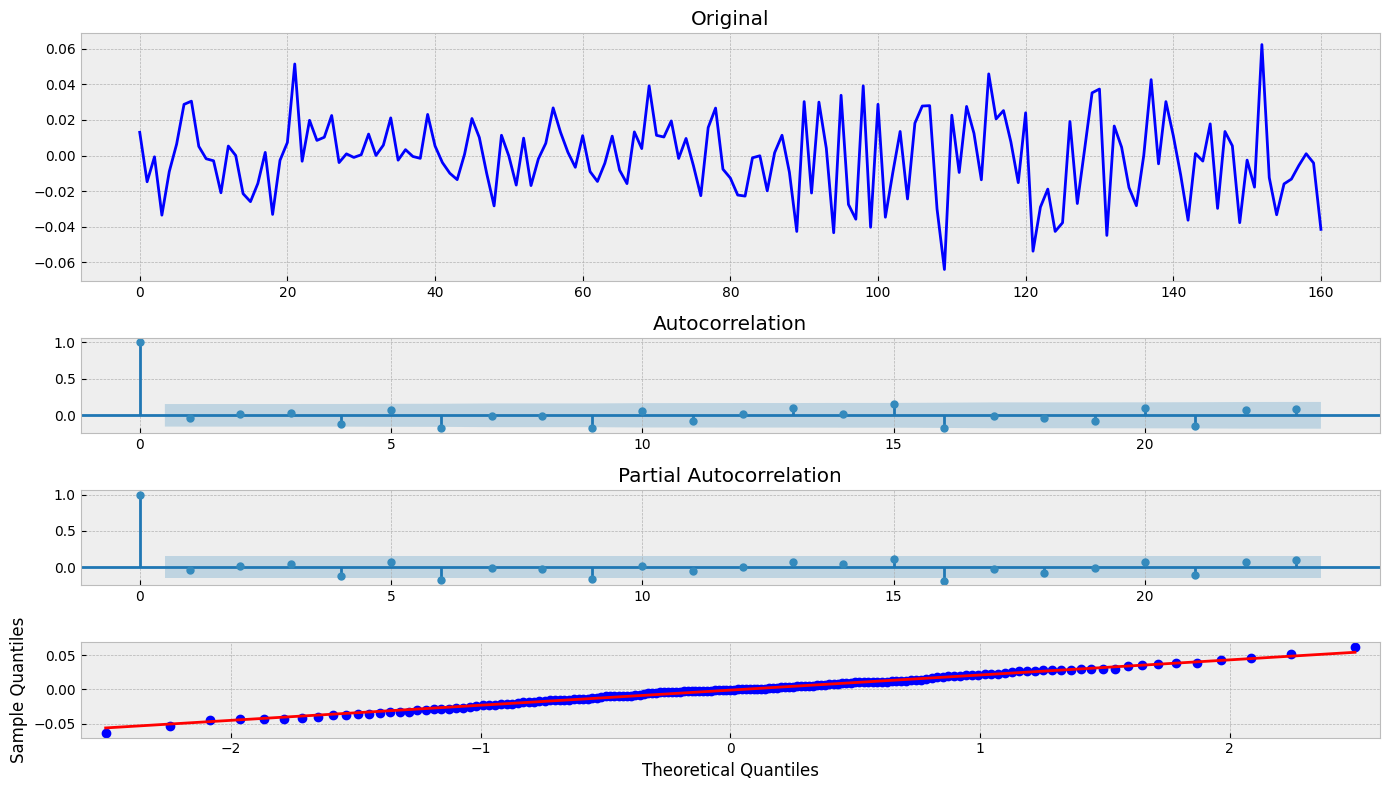

In [27]:
tsplot(res.resid)

In [32]:
# применим найденные с помощью ARIMA гиперпараметры для GARCH
p_ = order[0]
o_ = order[1]
q_ = order[2]


am = arch_model(series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 349.0563123356975
Iteration:     10,   Func. Count:     90,   Neg. LLF: 348.513932776513
Iteration:     15,   Func. Count:    130,   Neg. LLF: 348.131983952954
Iteration:     20,   Func. Count:    170,   Neg. LLF: 347.9555901528738
Optimization terminated successfully    (Exit mode 0)
            Current function value: 347.93039418828675
            Iterations: 22
            Function evaluations: 196
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -347.930
Distribution:      Standardized Student's t   AIC:                           709.861
Method:                  Maximum Likelihood   BIC:                           7

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


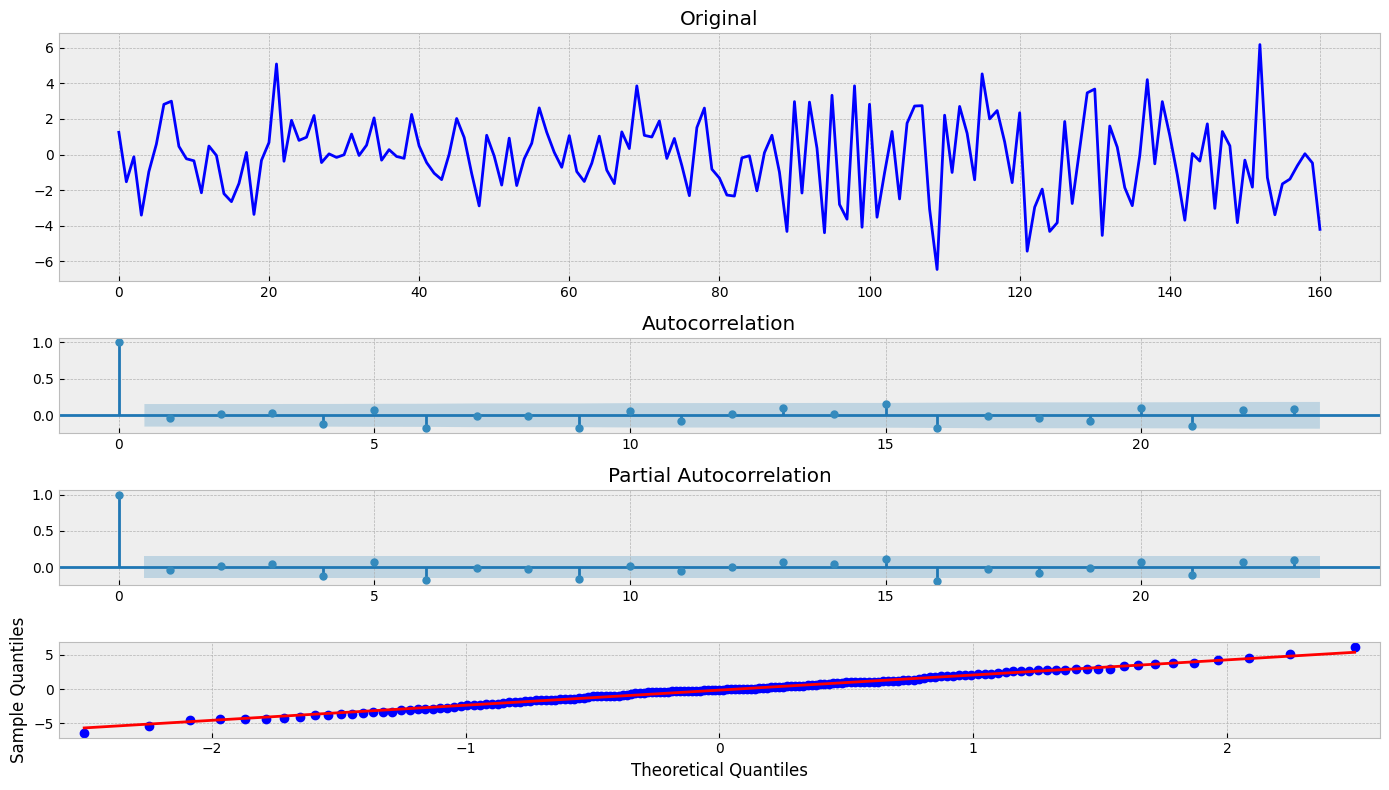

In [33]:
tsplot(res.resid)

In [34]:
forecast = res.forecast(horizon=100)

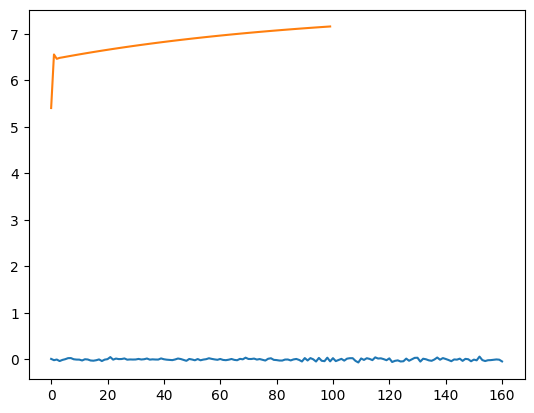

In [36]:
plt.plot(series)
# print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*100 + forecast.residual_variance.iloc[-1].values)

In [291]:
# res.forecast()
from statsmodels.graphics.tsaplots import plot_predict

### применение методов классического ML

In [37]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
s = pd.DataFrame(series['Close'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s.loc[:, f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80,890.19
11,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80
12,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51
13,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78
14,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43


In [48]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

#### линейная регрессия

In [51]:
from sklearn.linear_model import LinearRegression


In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)



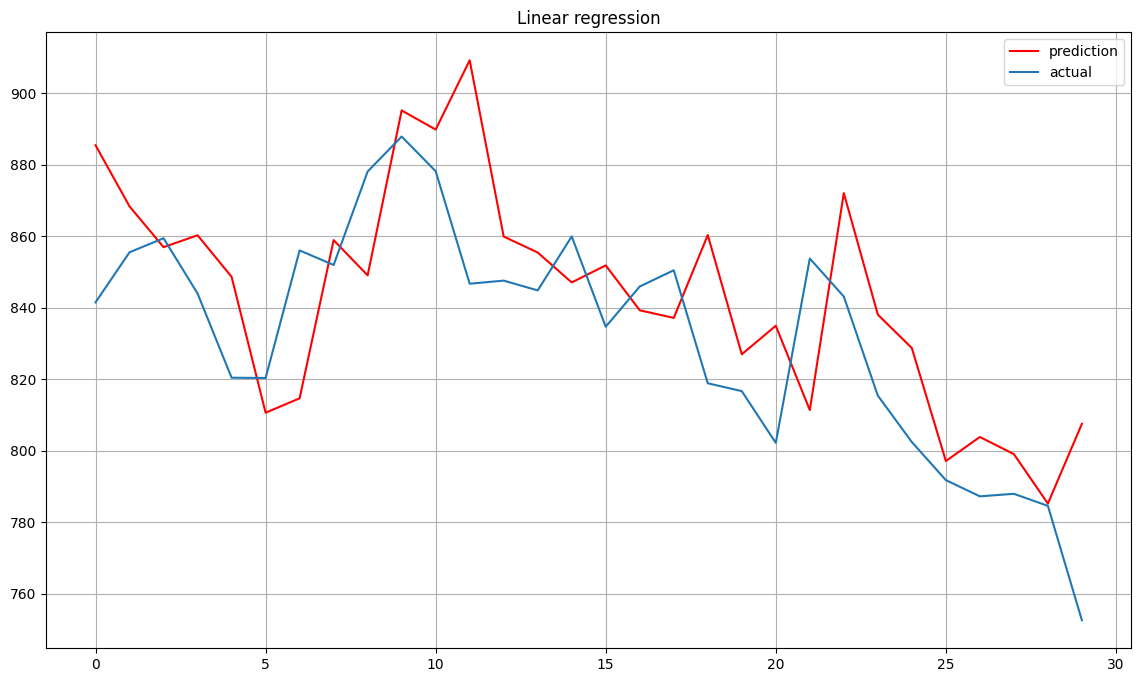

In [60]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

In [56]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,840.39,839.00,852.37,874.85,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80,890.19
1,812.94,840.39,839.00,852.37,874.85,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80
2,810.67,812.94,840.39,839.00,852.37,874.85,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51
3,816.55,810.67,812.94,840.39,839.00,852.37,874.85,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78
4,859.59,816.55,810.67,812.94,840.39,839.00,852.37,874.85,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,838.05,822.25,854.00,891.33,908.42,935.28,987.06,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84,852.38,908.87
110,815.65,838.05,822.25,854.00,891.33,908.42,935.28,987.06,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84,852.38
111,818.73,815.65,838.05,822.25,854.00,891.33,908.42,935.28,987.06,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84
112,848.02,818.73,815.65,838.05,822.25,854.00,891.33,908.42,935.28,987.06,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49


####  применение RandomForestRegressor

In [59]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
# print(classification_report(y_test, predicted))

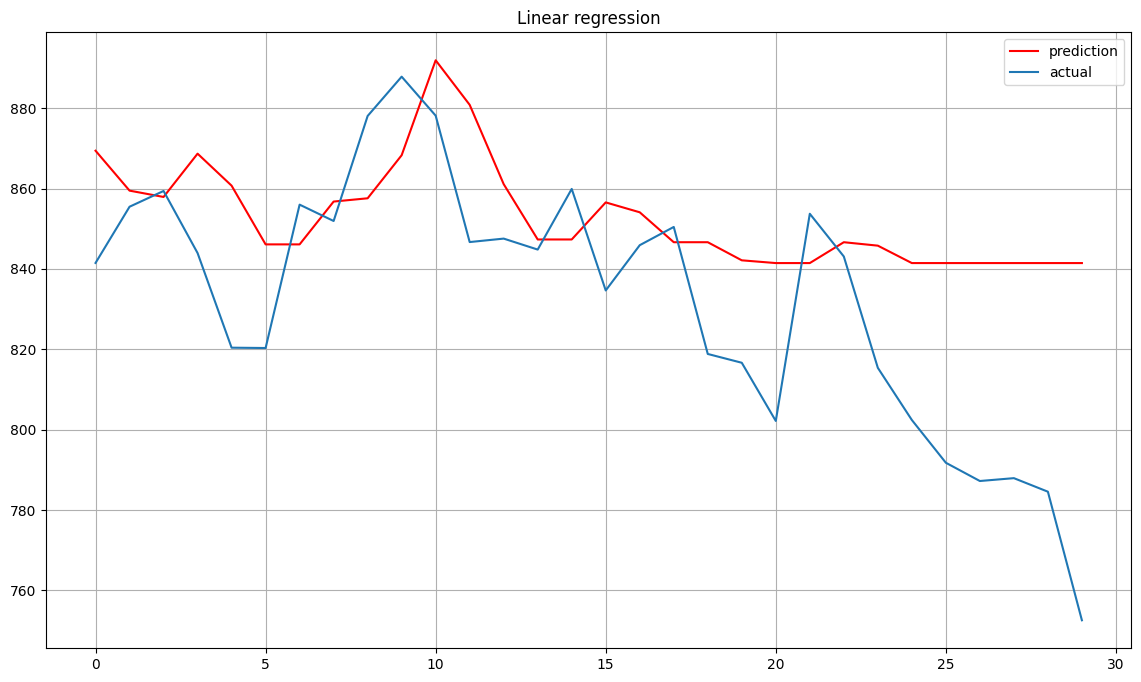

In [61]:
plt.figure(figsize=(14, 8))
plt.plot(predicted, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

#### применение LSTM

In [133]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [274]:
df_train = series.Close[:100].to_frame()
df_val = series.Close[100:130].to_frame()
df_test = series.Close[130:].to_frame()


In [275]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [262]:
# train_arr = series.Close
# train_arr , val_arr, test_arr = series.Close[:100], series.Close[100:130], series.Close[130:]

In [276]:
from torch.autograd import Variable

seq_len = 10

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [277]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

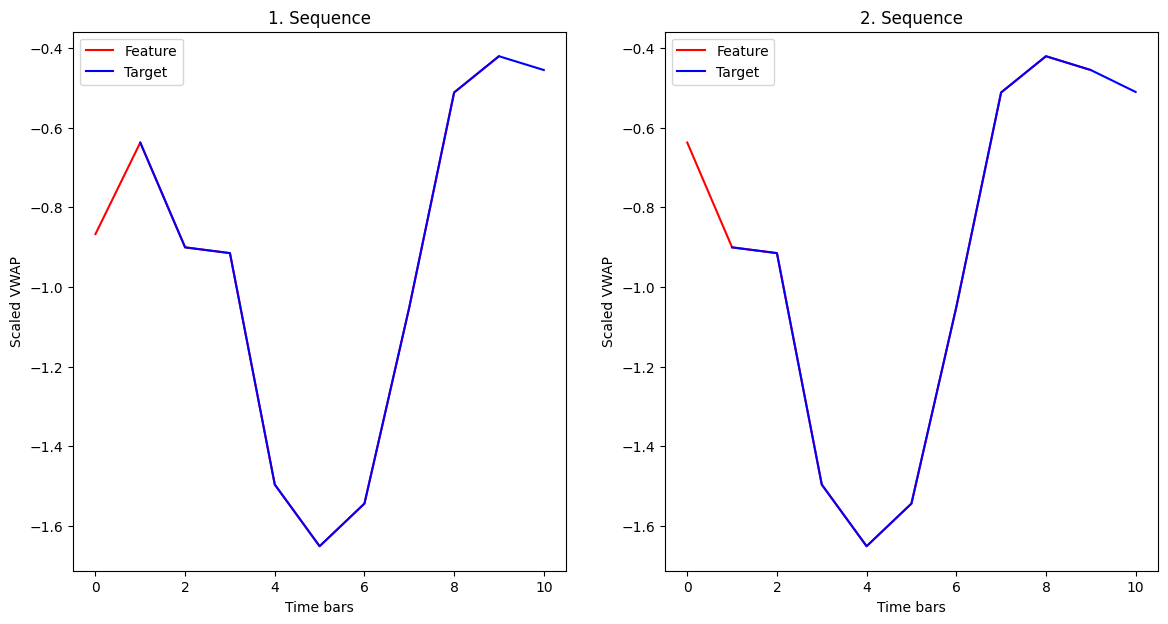

In [278]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [279]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [280]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=5,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [281]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [282]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [283]:
# Train
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)


In [284]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 1.12. Validation loss: 1.30. Avg future: 0.00. Elapsed time: 0.08s.
Epoch 2 Train loss: 1.04. Validation loss: 1.24. Avg future: 0.00. Elapsed time: 0.05s.
Epoch 3 Train loss: 0.97. Validation loss: 1.18. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 4 Train loss: 0.90. Validation loss: 1.12. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 5 Train loss: 0.81. Validation loss: 1.05. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 6 Train loss: 0.75. Validation loss: 1.04. Avg future: 0.00. Elapsed time: 0.05s.
Epoch 7 Train loss: 0.74. Validation loss: 1.04. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 8 Train loss: 0.73. Validation loss: 1.03. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 9 Train loss: 0.72. Validation loss: 1.02. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 10 Train loss: 0.71. Validation loss: 1.02. Avg future: 0.00. Elapsed time: 0.04s.
Epoch 11 Train loss: 0.71. Validation loss: 1.02. Avg future: 0.00. Elapsed time: 0.05s.
Epoch 12 Train loss: 0.70. Val

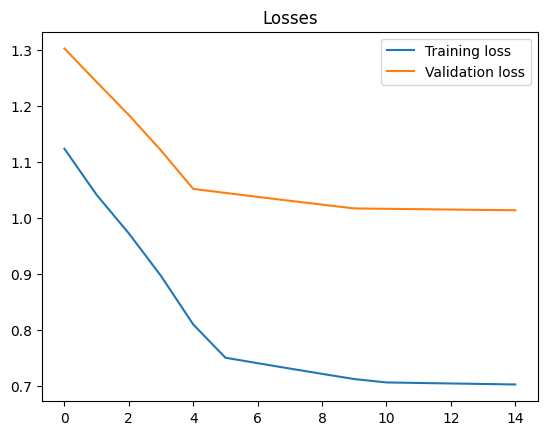

In [285]:
optimization_1.plot_losses()

Test loss 3.2749


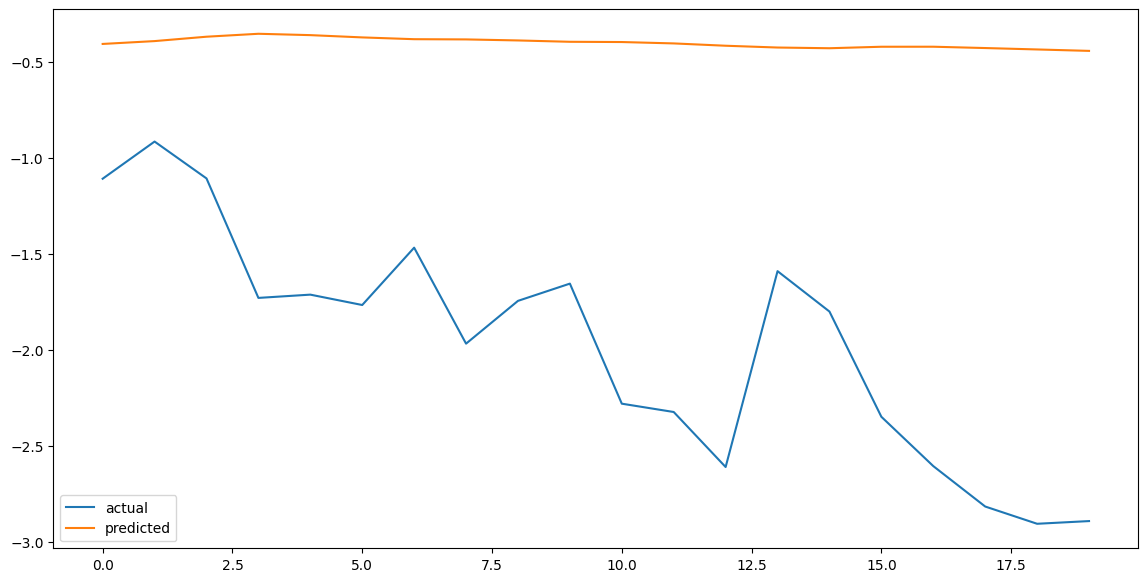

In [286]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=0, batch_size=5)

df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

ВЫВОД: В данном случае лучше всего себя показала Линейная регрессия.